In [2]:
import bindsnet

In [10]:
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes


In [9]:
network = Network()

In [11]:
# Create a layer of 100 LIF neurons with shape (10, 10).
layer = LIFNodes(n=100, shape=(10, 10))

In [12]:
network.add_layer(layer=layer, name="LIF population")

In [14]:
network.layers['LIF population']

LIFNodes()

In [18]:
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection

# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

# Connect the two layers.
connection = Connection(
    source=source_layer, target=target_layer
)

In [19]:
network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)
network.add_connection(
    connection=connection, source="A", target="B"
)

In [22]:
network.connections['A', 'B']

Connection(
  (source): Input()
  (target): LIFNodes()
)

In [27]:
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

network = Network()

source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

connection = Connection(
    source=source_layer, target=target_layer
)

# Create a monitor.
monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=500,  # Length of simulation (if known ahead of time).
)

In [28]:
network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)
network.add_connection(
    connection=connection, source="A", target="B"
)
network.add_monitor(monitor=monitor, name="B")


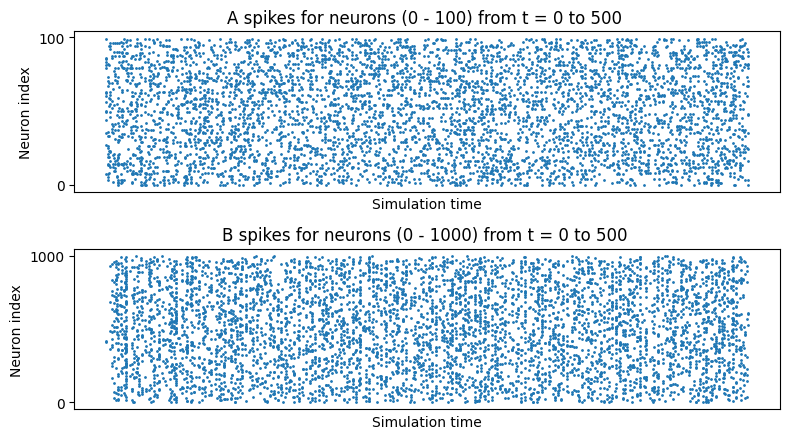

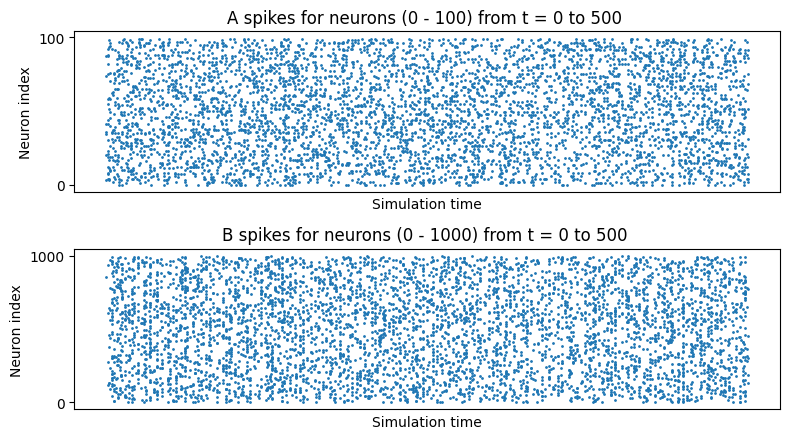

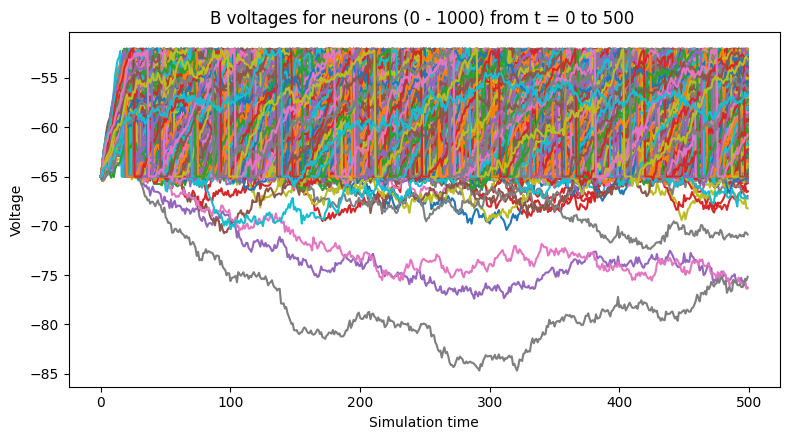

In [42]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

# Simulation time.
time = 500

# Create the network.
network = Network()

# Create and add input, output layers.
source_layer = Input(n=100)
target_layer = LIFNodes(n=1000)

network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)

# Create connection between input and output layers.
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    w=0.05 + 0.1 * torch.randn(source_layer.n, target_layer.n),  # Normal(0.05, 0.01) weights.
)

network.add_connection(
    connection=forward_connection, source="A", target="B"
)

# Create recurrent connection in output layer.
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1), # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="B", target="B"
)

# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")

# Create input spike data, where each spike is distributed according to Bernoulli(0.1).
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
inputs = {"A": input_data}

# Simulate network on input data.
network.run(inputs=inputs, time=time)

# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {
    "A": source_monitor.get("s"), "B": target_monitor.get("s")
}
voltages = {"B": target_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()

In [31]:
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre

# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
# Neurons involved in certain learning rules must record synaptic
# traces, a vector of short-term memories of the last emitted spikes.
source_layer = Input(n=100, traces=True)
target_layer = LIFNodes(n=1000, traces=True)

# Connect the two layers.
connection = Connection(
    source=source_layer, target=target_layer, update_rule=PostPre, nu=(1e-4, 1e-2)
)

In [39]:
target_monitor.get("s")

tensor([[[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]],

        ...,

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]]])

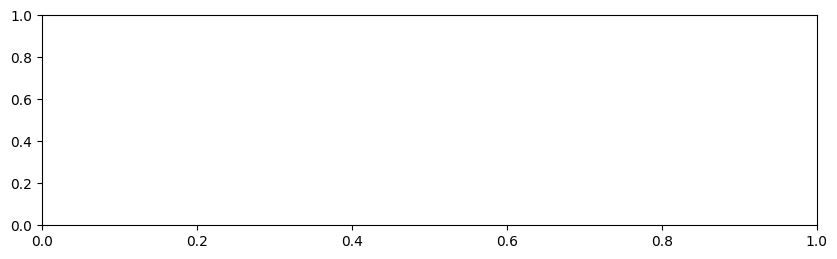

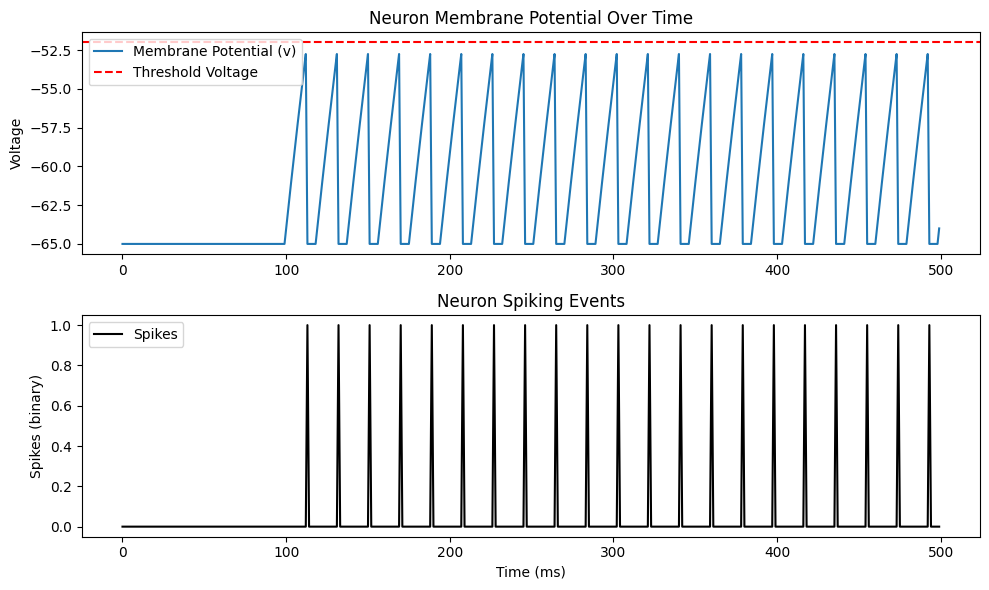

In [48]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes

# Simulation time
time = 500  # Total simulation time in ms

# Create the network
network = Network()

# Create a layer with a single LIF neuron
lif_layer = LIFNodes(n=1)  # 1 neuron in the layer
network.add_layer(layer=lif_layer, name="LIF")

# Monitor to record spikes and voltages
monitor = Monitor(obj=lif_layer, state_vars=("s", "v"), time=time)
network.add_monitor(monitor=monitor, name="LIF_monitor")

# Create input current (constant input over time)
input_current = torch.zeros(time, 1)  # Initialize zero input for all timesteps
input_current[100:] = 1.0  # Apply constant input current after 100 ms

# Dictionary of inputs to the network
inputs = {"LIF": input_current}

# Run the simulation
network.run(inputs=inputs, time=time)

# Retrieve the recorded data
spikes = monitor.get("s")  # Spiking events
voltages = monitor.get("v")  # Membrane potential (voltage)

# Reshape the voltages to be 1D for plotting
voltages = voltages.squeeze()  # Remove extra dimensions (shape: [500])

# Plot spikes and voltages
plt.figure(figsize=(10, 6))

# Plot the membrane potential (voltage)
plt.subplot(2, 1, 1)
plt.plot(voltages, label="Membrane Potential (v)")
plt.axhline(y=lif_layer.thresh.item(), color='r', linestyle='--', label="Threshold Voltage")
plt.title("Neuron Membrane Potential Over Time")
plt.ylabel("Voltage")
plt.legend()

# Plot the spikes
plt.subplot(2, 1, 2)
plt.plot(spikes.squeeze(), label="Spikes", color="k")  # Flatten the spikes for plotting
plt.title("Neuron Spiking Events")
plt.xlabel("Time (ms)")
plt.ylabel("Spikes (binary)")
plt.legend()

plt.tight_layout()
plt.show()


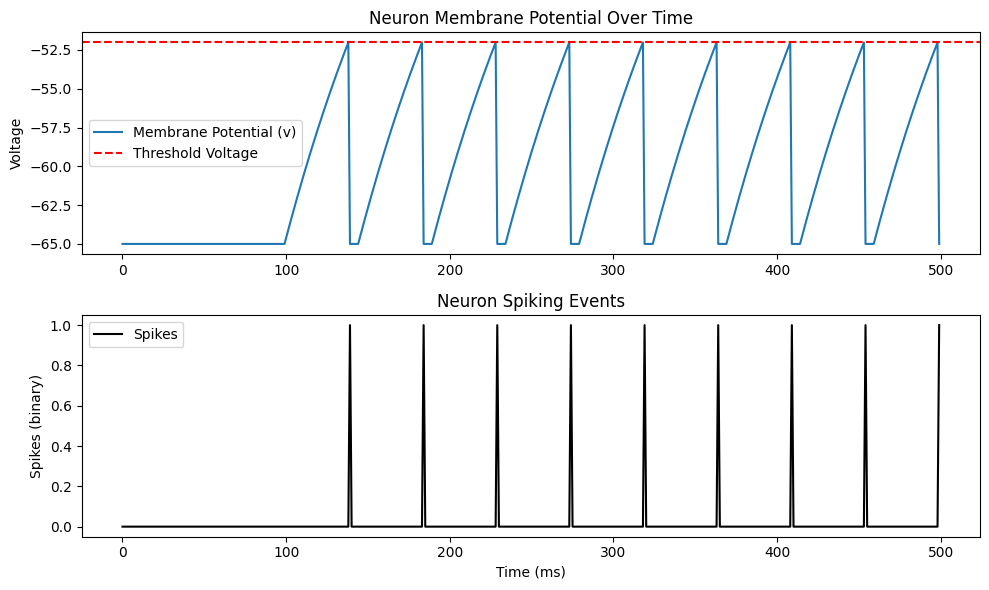

In [59]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes

# Simulation time
time = 500  # Total simulation time in ms

# Create the network
network = Network()

# Create a layer with a single LIF neuron
lif_layer = LIFNodes(n=1)  # 1 neuron in the layer
network.add_layer(layer=lif_layer, name="LIF")

# Monitor to record spikes and voltages
monitor = Monitor(obj=lif_layer, state_vars=("s", "v"), time=time)
network.add_monitor(monitor=monitor, name="LIF_monitor")

# Create input current (constant input over time)
input_current = torch.zeros(time, 1)  # Initialize zero input for all timesteps
input_current[100:] = 1.0* .4 # Apply constant input current after 100 ms

# Dictionary of inputs to the network
inputs = {"LIF": input_current}

# Run the simulation
network.run(inputs=inputs, time=time)

# Retrieve the recorded data
spikes = monitor.get("s")  # Spiking events
voltages = monitor.get("v")  # Membrane potential (voltage)

# Reshape the voltages to be 1D for plotting
voltages = voltages.squeeze()  # Remove extra dimensions (shape: [500])

# Plot spikes and voltages
plt.figure(figsize=(10, 6))

# Plot the membrane potential (voltage)
plt.subplot(2, 1, 1)
plt.plot(voltages, label="Membrane Potential (v)")
plt.axhline(y=lif_layer.thresh.item(), color='r', linestyle='--', label="Threshold Voltage")
plt.title("Neuron Membrane Potential Over Time")
plt.ylabel("Voltage")
plt.legend()

# Plot the spikes
plt.subplot(2, 1, 2)
plt.plot(spikes.squeeze(), label="Spikes", color="k")  # Flatten the spikes for plotting
plt.title("Neuron Spiking Events")
plt.xlabel("Time (ms)")
plt.ylabel("Spikes (binary)")
plt.legend()

plt.tight_layout()
plt.show()

What all factors will affects the firing of neuron;
* Voltage needs to be above Vth. 
        what all factors affect the Vth: 
            * the neurotransmitters
             neurotransmitters are released based on the spikes it receives at the axon terminal.
                spikes can be a train of spikes or individual spikes
             neurotransmitter from some other pathways as well - needs more research onto this.
    * frequency of spikes 
    * multiple spikes from different input neurons.






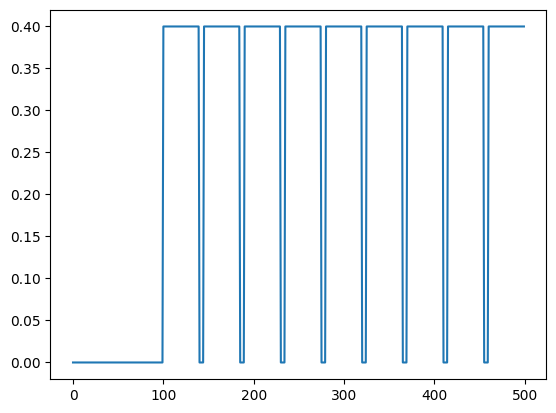

In [61]:
plt.plot(input_current)
plt.show()